In [ ]:
%matplotlib inline

## Logistic regressions

### Introduction

Logistic regression is an important model to solve classification problem, which is expressed specifically as:
$$
\begin{aligned}
& P(y=1 \mid x)=\frac{1}{1+\exp \left(-x^T \beta\right)}, \\
& P(y=0 \mid x)=\frac{1}{1+\exp \left(x^T \beta\right)},
\end{aligned}
$$
where $\beta$ is an unknown parameter vector that to be estimated. Since we expect only a few explanatory variables contributing to predicting $y$, we assume $\beta$ is sparse vector with sparsity level $s$.

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:

<a id='loss'></a>
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{y_i x_i^T \beta-\log \left(1+\exp \left(x_i^T \beta\right)\right)\right\}, \text { s.t. }\|\beta\|_0 \leq s \tag{1}
$$ 

We first import necessary packages. 

In [1]:
import jax.numpy as jnp
import numpy as np
from skscope import ScopeSolver
import numpy as np

Next, we define a data generator function to provide a way to generate suitable dataset for this task.

In [12]:
def make_logistic_data(n, p, k, seed):
    coef = np.zeros(p)
    np.random.seed(seed)
    coef[np.random.choice(np.arange(p), k, replace=False)] = np.random.choice([1, -1], k)
    # generate correlation matrix with exponential decay
    R = np.zeros((p, p))
    for i in range(p):
        for j in range(i, p):
            R[i, j] = 0.2 ** abs(i - j)
    R = R + R.T - np.identity(p)

    x = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=(n,))

    xbeta = np.matmul(x, coef)
    xbeta[xbeta > 30] = 30
    xbeta[xbeta < -30] = -30

    p = np.exp(xbeta) / (1 + np.exp(xbeta))
    y = np.random.binomial(1, p)

    return coef, (x, y)

We then use this function to generate a data set containg 500 observations and set only 5 of the 500 variables to have effect on the expectation of the response.

In [13]:
n, p, s = 500, 500, 5
true_params, (X, y) = make_logistic_data(n, p, s, 0)

Secondly, we define the loss function `logistic_loss` according to [1](#loss) that matches the data generating function `make_logistic_data`.

In [14]:
def logistic_loss(params):
    xbeta = X @ params
    return jnp.sum(jnp.logaddexp(0, xbeta) - y * xbeta)

Here, we use SIC to decide the optimal support size. There are four types of information criterion can be implemented in `skscope.utilities`:
- Akaike information criterion (AIC)
- Bayesian information criterion (BIC)
- Extend BIC (EBIC)
- Special information criterion (SIC)
  
You can just need one line of code to call any IC, here we use SIC:

In [17]:
from skscope.utilities import SIC
solver = ScopeSolver(p, sparsity = range(10), sample_size = n, ic_method = SIC)
params = solver.solve(logistic_loss, jit=True)

We can further compare the coefficients estimated by `skscope` and the real coefficients in three-fold:

* The true support set and the estimated support set

* The true nonzero parameters and the estimated nonzero parameters

* The true loss value and the estimated values

In [21]:
print("True support set: ", (true_params.nonzero()[0]))
print("Estimated support set: ", (solver.support_set))
print("True parameters: ", true_params[true_params.nonzero()])
print("Estimated parameters: ", solver.params[solver.support_set])
print("True loss value: ", logistic_loss(true_params))
print("Estimated loss value: ", logistic_loss(solver.params))

True support set:  [ 90  97 340 395 477]
Estimated support set:  [ 90  97 340 395 477]
True parameters:  [ 1. -1.  1. -1. -1.]
Estimated parameters:  [ 1.30554097 -1.04517175  1.05883086 -1.25463866 -1.17597009]
True loss value:  200.56027
Estimated loss value:  197.75107


The sparse signal recovering from the noisy observations to visualize the results.

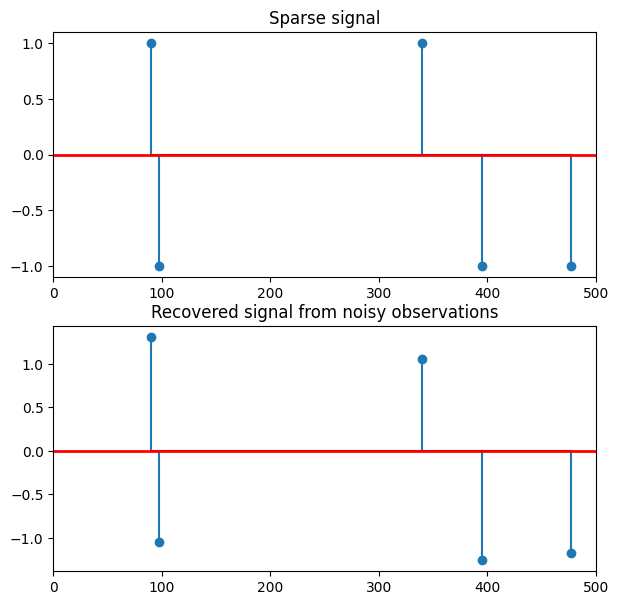

In [22]:
import matplotlib.pyplot as plt
(inx_true,) =  true_params.nonzero()
(inx_est,) =  solver.params.nonzero()

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(inx_true, true_params[inx_true], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(inx_est, solver.params[inx_est], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()

Considering `skscope` also support cross validation (CV), we will use CV to select the optimal support set and compare its runtime with that of SIC. We first record the runtime of using SIC. 

In [25]:
import time
# Record start time
start_time = time.time()

solver_ic = ScopeSolver(p, sparsity = range(10), sample_size = n, ic_method = SIC)
params_ic = solver_ic.solve(logistic_loss, jit=True)

# Calculate runtime
runtime = time.time() - start_time
print("Runtime of SIC:", runtime, "seconds")

True support set:  [ 90  97 340 395 477]
skscope estimated support set:  [ 90  97 340 395 477]
Runtime of SIC: 0.7247357368469238 seconds


Next, we implement the loss function for using CV to decide the optimal support size and record the runtime of CV.

In [26]:
def logistic_loss_cv(params, data):
    X, y = data
    xbeta = X @ params
    return jnp.sum(jnp.logaddexp(0, xbeta) - y * xbeta)

# Record start time
start_time = time.time()

solver_cv = ScopeSolver(p, sparsity = range(10), sample_size = n, cv = 5,
                        split_method=lambda data, index: (data[0][index, :], data[1][index]))
params_cv = solver_cv.solve(logistic_loss_cv, jit=True, data=(X, y))

# Variable selection accuracy
print("True support set: ", (true_params.nonzero()[0]))
print("skscope estimated support set: ", (solver_cv.support_set))

# Calculate runtime
runtime = time.time() - start_time
print("Runtime of CV:", runtime, "seconds")

True support set:  [ 90  97 340 395 477]
skscope estimated support set:  [ 90  97 340 395 477]
Runtime of CV: 4.354445219039917 seconds


Comparing the results of SIC and CV criteria, we find that while CV maintains high accuracy in variable selection, SIC exhibits a clear time advantage.

Finally, we compare the results under two different circumstances: using warm start and not.

> Hint: All solvers default to using warm start, which can slightly prolong computation time if not utilized.

As using warm start is the default strategy of `skscope`, the usage of `skscope` with warm start is the same as previous:

In [29]:
# Record start time
start_time = time.time()
solver_ws = ScopeSolver(p, sparsity = range(10), sample_size = n, cv = 5,
                        split_method=lambda data, index: (data[0][index, :], data[1][index]))
solver_ws.solve(logistic_loss_cv, jit=True, data=(X, y))

# Calculate runtime
runtime = time.time() - start_time
print("Runtime:", runtime, "seconds")
print("True support set: ", (true_params.nonzero()[0]))
print("Estimated support set: ", (solver_ws.support_set))

Runtime: 4.619333982467651 seconds


If we turn of the warm-start strategy in `skscope`, the code is change to:

In [32]:
# Record start time
start_time = time.time()
solver_nws = ScopeSolver(p, sparsity = range(10), sample_size = n, cv = 5,
                        split_method=lambda data, index: (data[0][index, :], data[1][index]))
solver_nws.warm_start = False
solver_nws.solve(logistic_loss_cv, jit=True, data=(X, y))
# Calculate runtime
runtime = time.time() - start_time
print("Runtime:", runtime, "seconds")
print("True support set: ", (true_params.nonzero()[0]))
print("Estimated support set: ", (solver_nws.support_set))

Runtime: 6.12715482711792 seconds


We can see that opening warm-start strategy accelerates the computation. 